In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
# from nltk.translate.bleu_score import corpus_bleu
# from nltk.translate.meteor_score import meteor_score
# from rouge import Rouge
import numpy as np
from PIL import Image
import configparser
import re
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import json

config = configparser.ConfigParser()
config.read("config.ini")

#importing local module 
from models.subclasses import *
from models.utilities import *
from models.predict import *
from models.train_utils import *
from models.evaluation_utils import *


2


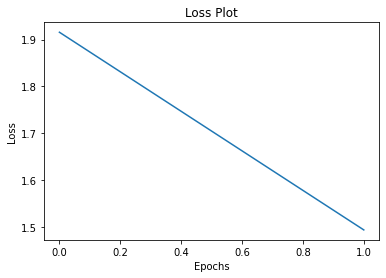

In [2]:
loss_plot = load_loss()
print(len(loss_plot))
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [3]:
units = int(config['config']['units'])
embedding_dim = int(config['config']['embedding_dim'])

vocabulary_size = int(config['config']['vocabulary_size'])


use_glove = bool(config['config']['use_glove'])
glove_dim = int(config['config']['glove_dim'])

In [4]:
val_image_paths, image_path_to_caption_val = import_files(shuffle= False, method = "val")

val_captions = []
img_name_vector_val = []
for image_path in val_image_paths:
  caption_list = image_path_to_caption_val[image_path]
  if len(caption_list)!=5:
    caption_list = caption_list[:5]
  val_captions.extend(caption_list)
  img_name_vector_val.extend([image_path] * len(caption_list))

5000


In [5]:
len(val_captions)

25000

In [6]:
train_image_paths, image_path_to_caption_train = import_files(shuffle= False, method = "train")

train_captions = []
img_name_vector_train = []
for image_path in train_image_paths:
  caption_list = image_path_to_caption_train[image_path]
  if len(caption_list)!=5:
    caption_list = caption_list[:5]
  train_captions.extend(caption_list)
  img_name_vector_train.extend([image_path] * len(caption_list))

2000


In [7]:
len(train_captions)

10000

In [8]:
_, _, vocabulary, _ = load_dataset()

In [9]:
word_to_index_val, index_to_word_val, tokenizer_val, cap_vector_val = tokenization(val_captions, max_length, vocabulary_size)

In [10]:
word_to_index_train, index_to_word_train, tokenizer_train, cap_vector_train = tokenization(train_captions, max_length, vocabulary_size)

In [11]:
new_glove_path = f"./dataset/glove.6B/new_glove.6B.{glove_dim}d.pkl"
tuned_glove = pickle.load(open(new_glove_path, "rb"))
len(tuned_glove)

1581

In [12]:
embeddings_index = {}

if use_glove:
    glove_path = f"./dataset/glove.6B/glove.6B.{glove_dim}d.txt"

    with open(glove_path, encoding="utf-8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    embeddings_index.update(tuned_glove)

    print("Found %s word vectors." % len(embeddings_index))

    vocabulary = tokenizer_train.get_vocabulary()
    word_index = dict(zip(vocabulary, range(len(vocabulary))))

    num_tokens = len(vocabulary) +2
    embedding_dim = 100
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

Found 401581 word vectors.
Converted 4543 words (118 misses)


In [13]:
encoder = CNN_Encoder(embedding_dim)
if use_glove:
    decoder = RNN_Decoder(embedding_dim, units, num_tokens, embedding_matrix)
else:
    decoder = RNN_Decoder(embedding_dim, units, tokenizer_train.vocabulary_size(), None)
image_features_extract_model = get_feature_extractor()

In [14]:
img_name_val, cap_val = split_data(img_name_vector_val, cap_vector_val ,
                                    image_features_extract_model, 1)

100%|██████████| 157/157 [00:39<00:00,  3.97it/s]


In [15]:
len(cap_vector_val)

25000

In [16]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
ckpt.restore(ckpt_manager.latest_checkpoint)

In [17]:
# getHypotheses(img_name_val, encoder, decoder,
#                     image_features_extract_model,word_to_index_train,
#                     index_to_word_train)

In [18]:
len(img_name_val)

25000

In [19]:
def makeResultFile(img_name_val, encoder, decoder,
                  image_features_extract_model, word_to_index_train,
                  index_to_word_train):

    result_list = []
    for i in range(0, len(img_name_val), 5):
        id = img_name_vector_val[i].split("val2017\\")[1].split(".")[0]
        cap = predict(img_name_val[i], encoder, decoder, image_features_extract_model,
                         word_to_index_train, index_to_word_train)
        
        if cap[-1] == "<end>":
            cap.remove("<end>")
             
        cap = ' '.join(cap)
        
        temp = {"image_id": int(id.lstrip('0')), "caption": cap}
        
        result_list.append(temp)
    
    with open('dataset\coco\\result\\result.json', 'w') as outfile:
        json.dump(result_list, outfile,sort_keys=True)
    
    return result_list

In [20]:
annotation_file = 'dataset\coco\\val\captions_val2017.json'
results_file = 'dataset\coco\\result\\result.json'

if os.path.exists(results_file):
    with open(results_file, 'r') as f:
        result = json.load(f)
else:
    result_a = makeResultFile(img_name_val, encoder, decoder,
                    image_features_extract_model, word_to_index_train,
                    index_to_word_train)

In [21]:
# create coco object and coco_result object
coco = COCO(annotation_file)
coco_result = coco.loadRes(results_file)

# create coco_eval object by taking coco and coco_result
coco_eval = COCOEvalCap(coco, coco_result)

coco_eval.evaluate()

# print output evaluation scores
for metric, score in coco_eval.eval.items():
    print(f'{metric}: {score:.3f}')

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.19s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 53817, 'reflen': 50921, 'guess': [53817, 48838, 43960, 39659], 'correct': [15268, 2255, 150, 19]}
ratio: 1.0568724102040208
Bleu_1: 0.284
Bleu_2: 0.114
Bleu_3: 0.035
Bleu_4: 0.012
computing METEOR score...
METEOR: 0.068
computing Rouge score...
ROUGE_L: 0.202
computing CIDEr score...
CIDEr: 0.014
computing SPICE score...
SPICE: 0.013
Bleu_1: 0.284
Bleu_2: 0.114
Bleu_3: 0.035
Bleu_4: 0.012
METEOR: 0.068
ROUGE_L: 0.202
CIDEr: 0.014
SPICE: 0.013


In [ ]:
imgIds = coco_eval.params['image_id']

In [ ]:
gts = {}
res = {}
for imgId in imgIds:
    gts[imgId] = coco.imgToAnns[imgId]
    res[imgId] = coco_result.imgToAnns[imgId]

In [ ]:
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
tokenizer = PTBTokenizer()
gts  = tokenizer.tokenize(gts)
res = tokenizer.tokenize(res)


In [ ]:
print(gts.keys() - res.keys() )

In [ ]:
len(gts.keys())

In [ ]:
len(res.keys())

In [ ]:
len(coco_result.imgToAnns[179765])

In [ ]:
len(coco.imgToAnns[179765])

In [ ]:
for id in imgIds:
    hypo = res[id]
    ref = gts[id]
    # print(len(hypo))
    if(len(hypo)!= 1):
        print(len(hypo))
        print(id)
    # print(ref)
    # break

In [ ]:
for i in range(10):
    print(' '.join([tf.compat.as_text(index_to_word_val(j).numpy())
                         for j in cap_val[i] if j not in [0]]).split('<start>')[1].split('<end>')[0])

In [ ]:
references = []
list_of_references = []

for i in range(len(img_name_val)):
    references.append(' '.join([tf.compat.as_text(index_to_word_val(j).numpy())
                                for j in cap_val[i] if j not in [0]]).split('<start>')[1].split('<end>')[0])
    
for i in range(0, len(img_name_val), 5):
    list_of_references.append(references[i:i+5])    

In [ ]:
len(list_of_references)

In [ ]:
len(cap_val)

In [ ]:
references[5:10]

In [ ]:
list_of_references[4]

In [ ]:
len(references)

In [ ]:
list_of_hypotheses = getHypotheses(img_name_val, encoder, decoder,
                    image_features_extract_model,word_to_index_train,
                    index_to_word_train)

In [ ]:
len(list_of_hypotheses)

In [ ]:
evaluate_all(len(img_name_val), list_of_references, list_of_hypotheses)

In [ ]:
# captions on the test set
# rid = np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]
num = np.random.randint(0, len(img_name_val)/5)
test_references = []
for i in range(5):
   test_references.append(list_of_references[num][i].split())

image = img_name_val[num*5]
# real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                          for i in cap_val[rid] if i not in [0]]).split()

result, attention_plot = evaluate(image, encoder, decoder, image_features_extract_model,
                                    word_to_index_train, index_to_word_train)

if result[-1] == "<end>":
    result.remove("<end>")

# if real_caption[0] == "<start>":
#     real_caption.remove("<start>")

rouge = Rouge()
list_of_hypotheses = [result]

print('Real Caption:', list_of_references[num][0])
print('Prediction Caption:', ' '.join(result))
print('Meteor: %f' % meteor_score(test_references, result))
print('Rouge: \n', rouge.get_scores(refs=list_of_references[num][0], hyps=' '.join(result), avg=True))
print('BLEU-1: %f' % corpus_bleu([test_references], list_of_hypotheses, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu([test_references], list_of_hypotheses, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu([test_references], list_of_hypotheses, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu([test_references], list_of_hypotheses, weights=(0.25, 0.25, 0.25, 0.25)))
plot_attention(image, result, attention_plot)